# Training Predictive Model - Full Model Extended Edition

### Import libraries

In [1]:
import datetime, json, random, IPython, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg
import torch, pytorch_lightning as pl
from ray import tune
from pytorch_lightning.loggers import TensorBoardLogger

from models import GazeDataModule, SingleModel, EyesModel, FullModel
from utils  import (
    get_config,
    tune_asha,
    get_best_results,
    save_model,
    plot_asha_param_grid,
    plot_parallel_param_loss,
    latest_tune_dir,
    _build_datamodule,
    _build_model,
    predict_screen_errors,
)

# project settings
SETTINGS, COLOURS, EYETRACKER, TF = get_config("config.ini")

%load_ext autoreload
%autoreload 2


To fix the "Import 'mpimg' could not be resolved" error, you need to install the `matplotlib` library, as `mpimg` is part of `matplotlib.image`. Use the `%pip install` magic command in Jupyter Notebook to install the required package.



Made changes.

To fix the "Import 'mpimg' could not be resolved" error, you need to install the `matplotlib` library, as `mpimg` is part of `matplotlib.image`. Use the `%pip install` magic command in Jupyter Notebook to install the required package.



Made changes.

### Dataset information

In [2]:
df = pd.read_csv("data/positions.csv")
region_map = np.load("data/region_map.npy").T

print(f"# of samples: {len(df)}")
coverage = np.count_nonzero(region_map > 0) / region_map.size * 100
print(f"Coverage: {coverage:.2f}% of screen surface")
print(f"Crop size: {SETTINGS['image_size']} x {SETTINGS['image_size']} px")

# of samples: 56525
Coverage: 92.46% of screen surface
Crop size: 64 x 64 px


### Fine tuning

In [3]:
search_space = {
    "seed":  tune.randint(0, 10000),
    "bs":    tune.choice([64, 128, 256]),
    "lr":    tune.loguniform(1e-4, 3e-3),
    "face_channels"     : tune.choice([(32, 64, 128), (48, 96, 192), (64, 128, 256)]),
    "eye_channels"      : tune.choice([(32, 64, 128), (48, 96, 192), (64, 128, 256)]),
    "head_pos_channels" : tune.choice([(16, 32, 64),  (24, 48, 96), (32, 64, 128)]),
    "hidden": tune.choice([256, 512, 768, 1024]),
}

analysis = tune_asha(
    search_space   = search_space,
    train_func     = "full",
    name           = "full/tune",
    img_types    = ["face_aligned", "l_eye", "r_eye", "head_pos", "head_angle"],
    num_samples    = 36,
    num_epochs     = 15,
    data_dir     = Path.cwd() / "data",
    seed           = 87,
)

2025-06-04 16:15:55,148	INFO worker.py:1852 -- Started a local Ray instance.
2025-06-04 16:15:58,687	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-06-04 16:15:58,697	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(_tune_wrapper pid=20316) Seed set to 1891
(_tune_wrapper pid=20316) Using bfloat16 Automatic Mixed Precision (AMP)
(_tune_wrapper pid=20316) Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
(_tune_wrapper pid=20316) GPU available: True (cuda), used: True
(_tune_wrapper pid=20316) TPU available: False, using: 0 TPU cores
(_tune_wrapper pid=20316) HPU available: False, using: 0 HPUs
(_tune_wrapper pid=20316) LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
(_tune_wrapper pid=20316) 
(_tune_wrapper pid=20316)   | Name       | Type              | Params | Mode  | In sizes       | Out sizes     
(_tune_wrapper pid=20316) -------------------------------------------------------------------------------------------
(_tune_wrapper pid=20316) 0 | criterion  | SmoothL1Loss      | 0      | train | ?              | ?             
(_tune_wrapper pid=20316) 1 | mae        | MeanAbsoluteError | 0     

Trial name,checkpoint_dir_name,date,done,hostname,iterations_since_restore,loss,mae,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
_tune_wrapper_6fc5e_00000,checkpoint_000014,2025-06-04_17-04-11,True,DESKTOP-B40NR52,15,65.0679,65.5662,127.0.0.1,20316,True,2882.59,172.545,2882.59,1749049451,15,6fc5e_00000
_tune_wrapper_6fc5e_00001,checkpoint_000001,2025-06-04_17-12-47,True,DESKTOP-B40NR52,2,159.472,159.972,127.0.0.1,1268,True,502.649,201.19,502.649,1749049967,2,6fc5e_00001
_tune_wrapper_6fc5e_00002,checkpoint_000000,2025-06-04_17-18-29,True,DESKTOP-B40NR52,1,235.851,236.35,127.0.0.1,5212,True,331.278,331.278,331.278,1749050309,1,6fc5e_00002
_tune_wrapper_6fc5e_00003,checkpoint_000003,2025-06-04_17-36-27,True,DESKTOP-B40NR52,4,74.7286,75.2271,127.0.0.1,16056,True,1065.57,240.163,1065.57,1749051387,4,6fc5e_00003
_tune_wrapper_6fc5e_00004,checkpoint_000000,2025-06-04_17-42-38,True,DESKTOP-B40NR52,1,218.67,219.17,127.0.0.1,20292,True,357.72,357.72,357.72,1749051758,1,6fc5e_00004
_tune_wrapper_6fc5e_00005,checkpoint_000000,2025-06-04_17-49-24,True,DESKTOP-B40NR52,1,416.609,417.109,127.0.0.1,18436,True,396.35,396.35,396.35,1749052164,1,6fc5e_00005
_tune_wrapper_6fc5e_00006,checkpoint_000001,2025-06-04_17-59-03,True,DESKTOP-B40NR52,2,188.519,189.019,127.0.0.1,14472,True,564.866,231.909,564.866,1749052743,2,6fc5e_00006
_tune_wrapper_6fc5e_00007,checkpoint_000000,2025-06-04_18-04-13,True,DESKTOP-B40NR52,1,263.06,263.559,127.0.0.1,19084,True,300.455,300.455,300.455,1749053053,1,6fc5e_00007
_tune_wrapper_6fc5e_00008,checkpoint_000000,2025-06-04_18-09-28,True,DESKTOP-B40NR52,1,223.246,223.746,127.0.0.1,9296,True,302.225,302.225,302.225,1749053368,1,6fc5e_00008
_tune_wrapper_6fc5e_00009,checkpoint_000000,2025-06-04_18-15-47,True,DESKTOP-B40NR52,1,241.66,242.16,127.0.0.1,4328,True,366.265,366.265,366.265,1749053747,1,6fc5e_00009


(_tune_wrapper pid=20316) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/full/tune_20250604-161552/6fc5e_00000/checkpoint_000000)
(_tune_wrapper pid=20316) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/full/tune_20250604-161552/6fc5e_00000/checkpoint_000001)
(_tune_wrapper pid=20316) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/full/tune_20250604-161552/6fc5e_00000/checkpoint_000002)
(_tune_wrapper pid=20316) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/src/logs/full/tune_20250604-161552/6fc5e_00000/checkpoint_000003)
(_tune_wrapper pid=20316) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/Youssef/Desktop/TFG/eye-tracker-vocacions/s

Best hyperparameters:  {'seed': 1891, 'bs': 64, 'lr': 0.0009759343046486212, 'face_channels': (32, 64, 128), 'eye_channels': (32, 64, 128), 'head_pos_channels': (16, 32, 64), 'hidden': 256}


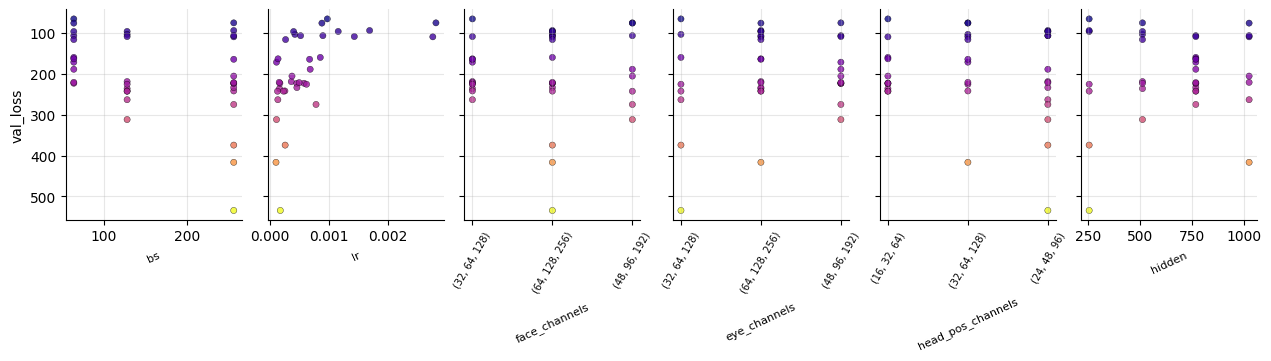

WindowsPath('media/images/final_full_explore_scatter.png')

In [4]:
plot_asha_param_grid(
    analysis,
    params=("bs", "lr",
            "face_channels", "eye_channels", "head_pos_channels",
            "hidden"),
    save_path="media/images/final_full_explore_scatter.png",
)

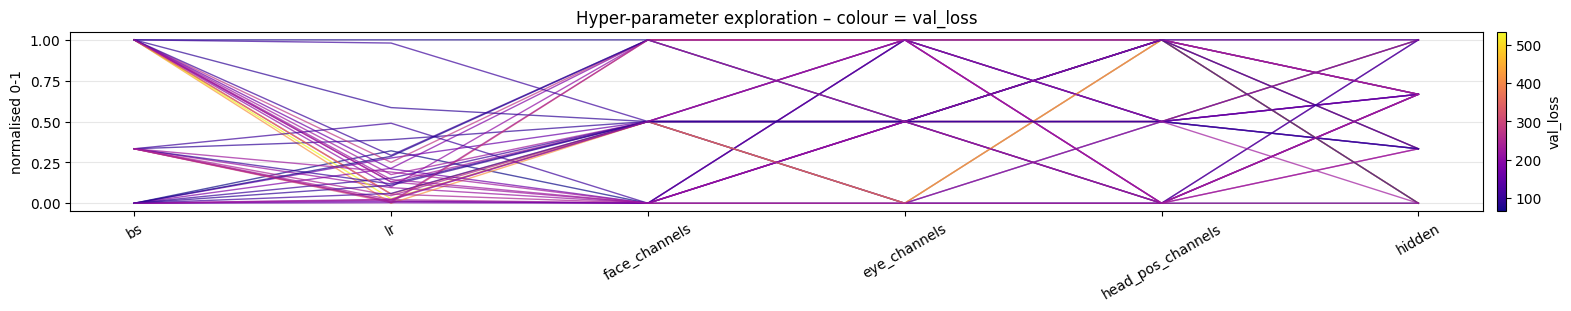

WindowsPath('media/images/final_full_explore_parallel.png')

In [5]:
plot_parallel_param_loss(
    analysis,
    cols=("bs", "lr",
          "face_channels", "eye_channels", "head_pos_channels",
          "hidden"),
    save_path="media/images/final_full_explore_parallel.png",
)

### Training

In [6]:
start_time = datetime.datetime.now().strftime("%Y-%b-%d %H-%M-%S")

tune_dir = Path.cwd() / "logs" / "full"
best_cfg = get_best_results(latest_tune_dir(tune_dir))
pl.seed_everything(best_cfg["seed"])

dm = GazeDataModule(
    data_dir = Path.cwd() / "data",
    batch_size = best_cfg["bs"],
    img_types = ["face_aligned", "l_eye", "r_eye", "head_pos", "head_angle"],
    seed = best_cfg["seed"],
)

model = _build_model(best_cfg, [
    "face_aligned", "l_eye", "r_eye", "head_pos", "head_angle"
])

trainer = pl.Trainer(
    max_epochs = 100,
    accelerator = "auto",
    devices = "auto",
    precision = "bf16-mixed",
    logger = TensorBoardLogger(
        save_dir = Path.cwd() / "logs",
        name     = f"full/final/{start_time}",
        log_graph = True,
    ),
    callbacks = [
        pl.callbacks.ModelCheckpoint(
            filename = "best",
            monitor  = "val_loss",
            mode     = "min",
            save_last = True,
            save_top_k = 1,
        )
    ],
)

trainer.fit(model, datamodule=dm)
best_path = trainer.checkpoint_callback.best_model_path
state = torch.load(best_path, map_location="cpu", weights_only=False)
model.load_state_dict(state["state_dict"])

out_dir = Path.cwd() / "logs" / "full" / "final" / start_time
out_dir.mkdir(parents=True, exist_ok=True)

save_model(
    model.cpu(),
    best_cfg,
    out_dir / "eyetracking_model.pt",
    out_dir / "eyetracking_config.json",
)

Seed set to 1891
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Best of 'c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\full\tune_20250604-161552' ---

Directory: 6fc5e_00000
Loss: 65.07
Pixel error: 8.07
Hyperparameters...
- seed: 1891
- bs: 64
- lr: 0.0009759343046486212
- face_channels: [32, 64, 128]
- eye_channels: [32, 64, 128]
- head_pos_channels: [16, 32, 64]
- hidden: 256


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode  | In sizes       | Out sizes     
-------------------------------------------------------------------------------------------
0 | criterion  | SmoothL1Loss      | 0      | train | ?              | ?             
1 | mae        | MeanAbsoluteError | 0      | train | ?              | ?             
2 | mse        | MeanSquaredError  | 0      | train | ?              | ?             
3 | rmse       | MeanSquaredError  | 0      | train | ?              | ?             
4 | face_stack | ConvStack         | 93.5 K | train | [1, 3, 64, 64] | [1, 128, 1, 1]
5 | l_stack    | ConvStack         | 93.5 K | train | [1, 3, 64, 64] | [1, 128, 1, 1]
6 | r_stack    | ConvStack         | 93.5 K | train | [1, 3, 64, 64] | [1, 128, 1, 1]
7 | head_stack | ConvStack         | 23.4 K | train | [1, 1, 64, 64] | [1, 64, 1, 1] 
8 | regressor  | Sequential        | 115 K  | train | [1, 449]       | [1, 2]        
-----

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


### Model Evaluation

In [7]:
test_results = trainer.test(ckpt_path="best", datamodule=dm)[0]

loss = test_results["test_loss_epoch"]
mae  = test_results["test_mae_epoch"]

mse  = test_results.get("test_mse_epoch",  test_results.get("test_mse"))
rmse = test_results.get("test_rmse_epoch", test_results.get("test_rmse"))

print("────────  Test set  ────────")
print(f"MSE   : {mse:8.2f}  px²")
print(f"RMSE  : {rmse:8.2f}  px")
print(f"MAE   : {mae:8.2f}  px")
print(f"Loss  : {loss:8.2f}  (Smooth-L1)")

Restoring states from the checkpoint path at c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\full/final/2025-Jun-05 08-18-08\version_0\checkpoints\best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\.venv\Lib\site-packages\pytorch_lightning\loggers\tensorboard.py:200: Could not log computational graph to TensorBoard: The `input_array` or `model.example_input_array` has type <class 'list'> which can't be traced by TensorBoard. Make the input array a tuple representing the positional arguments to the model's `forward()` implementation.
Loaded model weights from the checkpoint at c:\Users\Youssef\Desktop\TFG\eye-tracker-vocacions\src\logs\full/final/2025-Jun-05 08-18-08\version_0\checkpoints\best.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │     27.69532585144043     │
│      test_mae_epoch       │     28.19107437133789     │
│         test_mse          │    1517.2708740234375     │
│         test_rmse         │     38.50370407104492     │
└───────────────────────────┴───────────────────────────┘

────────  Test set  ────────
MSE   :  1517.27  px²
RMSE  :    38.50  px
MAE   :    28.19  px
Loss  :    27.70  (Smooth-L1)


  0%|          | 0/56525 [00:00<?, ?it/s]

Average error: 37.22px over 5653 samples


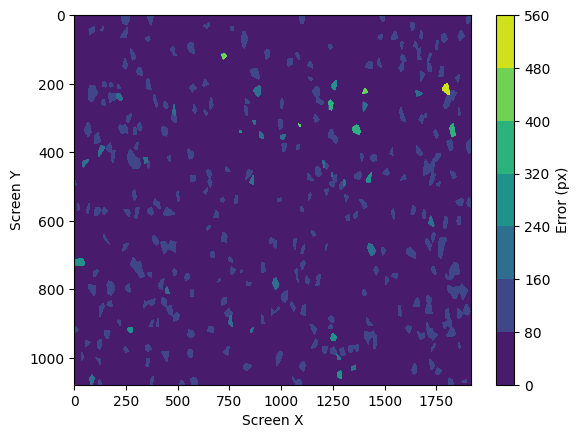

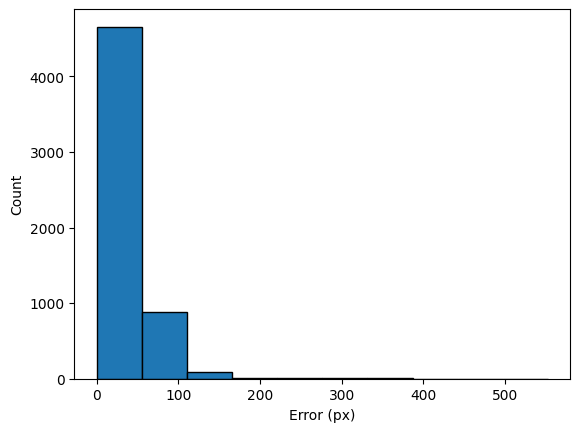

In [8]:
predict_screen_errors(
    "face_aligned", "l_eye", "r_eye", "head_pos", "head_angle",
    path_model  = out_dir/"eyetracking_model.pt",
    path_config = out_dir/"eyetracking_config.json",
    path_plot   = out_dir/"error_heatmap_full.png",
    path_errors = out_dir/"errors.npy",
    steps       = 10,
)